In [ ]:
# import libraries
import pandas as pd
import numpy as np
import sys
import sklearn
import io
import random


from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
import pickle
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.ensemble import GradientBoostingClassifier
#from pycaret.classification import *


import tensorflow as tf
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense,Dropout,LSTM,Embedding,SimpleRNN, GRU,Activation,Flatten
from tensorflow.keras.layers import Conv1D,MaxPool1D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,CSVLogger
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import sequence
from sklearn.metrics import (precision_score, recall_score,confusion_matrix,f1_score, accuracy_score,mean_squared_error,mean_absolute_error)
import pandas as pd
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
import matplotlib.pyplot as plt

# Đọc và EDA dữ liệu


*   Train: train+.txt (KDDtrain.txt)
*   Test: test+.txt (KDDtest.txt)



In [ ]:
from google.colab import files
files.upload()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
datacols = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]

#training set
df_train = pd.read_csv("NSL_KDD_Train.csv",header=None, names = datacols)
#testing set
df_test = pd.read_csv("NSL_KDD_Test.csv", header=None, names = datacols)

print('Dimensions of the Training set:',df_train.shape)
print('Dimensions of the Test set:',df_test.shape)

Dimensions of the Training set: (125973, 42)
Dimensions of the Test set: (22544, 42)


In [ ]:
#EDA
print('Label distribution in the Training set:')
print("****************************************")
print(df_train['label'].value_counts())

Label distribution in the Training set:
****************************************
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: label, dtype: int64


In [ ]:
print('Label distribution in the Test set:')
print("**************************************")
print(df_test['label'].value_counts())

Label distribution in the Test set:
**************************************
normal             9711
neptune            4657
guess_passwd       1231
mscan               996
warezmaster         944
apache2             737
satan               735
processtable        685
smurf               665
back                359
snmpguess           331
saint               319
mailbomb            293
snmpgetattack       178
portsweep           157
ipsweep             141
httptunnel          133
nmap                 73
pod                  41
buffer_overflow      20
multihop             18
named                17
ps                   15
sendmail             14
rootkit              13
xterm                13
teardrop             12
xlock                 9
land                  7
xsnoop                4
ftp_write             3
worm                  2
loadmodule            2
perl                  2
sqlattack             2
udpstorm              2
phf                   2
imap                  1
Name: label, 

# Tiền xử lí


*   Chuẩn hóa kiểu dữ liệu: 4 cột biến phân loại: protocol_type (column 2), service (column 3), flag (column 4) và label (col42)

*   Mã hóa dữ liệu với one-hot, biến đổi dữ liệu phân loại -> nhị phân (0, 1)



## Quan sát các phân loại của protocol_type (column 2), service (column 3), flag (column 4) và label (col42)


*   Training set:
** Feature 'protocol_type' has 3 categories
** Feature 'service' has 70 categories
** Feature 'flag' has 11 categories
** Feature 'label' has 23 categories



*   Test set:
** Feature 'protocol_type' has 3 categories
** Feature 'service' has 64 categories
** Feature 'flag' has 11 categories
** Feature 'label' has 38 categories




In [ ]:
#Training set
print('Training set:')
for datacols in df_train.columns:
    if df_train[datacols].dtypes == 'object' :
        unique_cat = len(df_train[datacols].unique())
        print("Feature '{datacols}' has {unique_cat} categories".format(datacols=datacols, unique_cat=unique_cat))

print()
print('Distribution of categories in service:')
print(df_train['service'].value_counts().sort_values(ascending=False).head())

Training set:
Feature 'protocol_type' has 3 categories
Feature 'service' has 70 categories
Feature 'flag' has 11 categories
Feature 'label' has 23 categories

Distribution of categories in service:
http        40338
private     21853
domain_u     9043
smtp         7313
ftp_data     6860
Name: service, dtype: int64


In [ ]:
# Test set
print('Test set:')
for datacols in df_test.columns:
    if df_test[datacols].dtypes == 'object' :
        unique_cat = len(df_test[datacols].unique())
        print("Feature '{datacols}' has {unique_cat} categories".format(datacols=datacols, unique_cat=unique_cat))

Test set:
Feature 'protocol_type' has 3 categories
Feature 'service' has 64 categories
Feature 'flag' has 11 categories
Feature 'label' has 38 categories


## LabelEncoder  với protocol_type (column 2), service (column 3), flag (column 4)


*   Đánh số các phân loại
*   Mục danh sách



In [ ]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
categorical_columns=['protocol_type', 'service', 'flag']

df_categorical_values = df_train[categorical_columns]
testdf_categorical_values = df_test[categorical_columns]

#Mỗi bộ phân loại () 
df_categorical_values.head()

,protocol_type,service,flag
0,tcp,ftp_data,SF
1,udp,other,SF
2,tcp,private,S0
3,tcp,http,SF
4,tcp,http,SF


In [ ]:
# protocol type
unique_protocol=sorted(df_train.protocol_type.unique())
string1 = 'Protocol_type_'
unique_protocol2=[string1 + x for x in unique_protocol]
print(unique_protocol2)
print('--------------------')

# service
unique_service=sorted(df_train.service.unique())
string2 = 'service_'
unique_service2=[string2 + x for x in unique_service]
print(unique_service2)
print('--------------------')

# flag
unique_flag=sorted(df_train.flag.unique())
string3 = 'flag_'
unique_flag2=[string3 + x for x in unique_flag]
print(unique_flag2)
print('--------------------')

# put together
dumcols=unique_protocol2 + unique_service2 + unique_flag2


#do it for test set
unique_service_test=sorted(df_test.service.unique())
unique_service2_test=[string2 + x for x in unique_service_test]
testdumcols=unique_protocol2 + unique_service2_test + unique_flag2

['Protocol_type_icmp', 'Protocol_type_tcp', 'Protocol_type_udp']
--------------------
['service_IRC', 'service_X11', 'service_Z39_50', 'service_aol', 'service_auth', 'service_bgp', 'service_courier', 'service_csnet_ns', 'service_ctf', 'service_daytime', 'service_discard', 'service_domain', 'service_domain_u', 'service_echo', 'service_eco_i', 'service_ecr_i', 'service_efs', 'service_exec', 'service_finger', 'service_ftp', 'service_ftp_data', 'service_gopher', 'service_harvest', 'service_hostnames', 'service_http', 'service_http_2784', 'service_http_443', 'service_http_8001', 'service_imap4', 'service_iso_tsap', 'service_klogin', 'service_kshell', 'service_ldap', 'service_link', 'service_login', 'service_mtp', 'service_name', 'service_netbios_dgm', 'service_netbios_ns', 'service_netbios_ssn', 'service_netstat', 'service_nnsp', 'service_nntp', 'service_ntp_u', 'service_other', 'service_pm_dump', 'service_pop_2', 'service_pop_3', 'service_printer', 'service_private', 'service_red_i', 'serv

In [ ]:
# train set
df_categorical_values_enc=df_categorical_values.apply(LabelEncoder().fit_transform)
print('Dimensions of the df_categorical_values:',df_categorical_values.shape)
print(df_categorical_values.head())
print('--------------------')

print('Dimensions of the df_categorical_values_enc:',df_categorical_values_enc.shape)
print(df_categorical_values_enc.head())
# test set
testdf_categorical_values_enc=testdf_categorical_values.apply(LabelEncoder().fit_transform)

Dimensions of the df_categorical_values: (125973, 3)
  protocol_type   service flag
0           tcp  ftp_data   SF
1           udp     other   SF
2           tcp   private   S0
3           tcp      http   SF
4           tcp      http   SF
--------------------
Dimensions of the df_categorical_values_enc: (125973, 3)
   protocol_type  service  flag
0              1       20     9
1              2       44     9
2              1       49     5
3              1       24     9
4              1       24     9


## One-Hot-Encoding với protocol_type (column 2), service (column 3), flag (column 4)

In [ ]:
# train set
enc = OneHotEncoder(categories='auto')
df_categorical_values_encenc = enc.fit_transform(df_categorical_values_enc)
df_cat_data = pd.DataFrame(df_categorical_values_encenc.toarray(),columns=dumcols)

# test set
testdf_categorical_values_encenc = enc.fit_transform(testdf_categorical_values_enc)
testdf_cat_data = pd.DataFrame(testdf_categorical_values_encenc.toarray(),columns=testdumcols)

## Gộp dữ liệu đã chuẩn hóa của protocol_type (column 2), service (column 3), flag (column 4) vào vào data

In [ ]:
trainservice=df_train['service'].tolist()
testservice= df_test['service'].tolist()
difference=list(set(trainservice) - set(testservice))
string = 'service_'
difference=[string + x for x in difference]

for col in difference:
    testdf_cat_data[col] = 0

print(df_cat_data.shape)    
print(testdf_cat_data.shape)

(125973, 84)
(22544, 84)


In [ ]:
# train data
newdf=df_train.join(df_cat_data)
newdf.drop('flag', axis=1, inplace=True)
newdf.drop('protocol_type', axis=1, inplace=True)
newdf.drop('service', axis=1, inplace=True)

# test data
newdf_test=df_test.join(testdf_cat_data)
newdf_test.drop('flag', axis=1, inplace=True)
newdf_test.drop('protocol_type', axis=1, inplace=True)
newdf_test.drop('service', axis=1, inplace=True)

print(newdf.shape)
print(newdf_test.shape)

(125973, 123)
(22544, 123)


## Chuẩn hóa kiểu dữ liệu với label (col42) CHƯA LIỆT KÊ XONG
label gồm 5 nhsom được đánh số từ 0 ->4 như sau:

* Normal -> 0

* DoS (1): neptune, back, land, pod, smurf, teardrop, mailbomb, apache2,processtable, udpstorm, worm,  

* Probe (2): ipsweep, nmap, portsweep, satan, mscan, saint


* R2L (3): ftp_write, guess_passwd, imap, multihop, phf, spy, warezclient, warezmaster, sendmail, named, snmpgetattack, snmpguess, xlock, xsnoop, httptunnel 

* U2R (4): buffer_overflow, loadmodule, perl, rootkit, ps, sqlattack, xterm

Một số loại tấn công chỉ xuất hiện ở tập test như xterm, mscan,...

Sau khi chuẩn hóa, ta đem label lại vào data. Đồng thời, ta thêm một thuộc tính "class" để phân biệt trang thái normal (0) và attack(1)







In [ ]:
# Convert the "label" catagorical values into numerical values

labeldf=newdf['label']
labeldf_test=newdf_test['label']

# change the label column
newlabeldf=labeldf.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
                           'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2
                           ,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,
                           'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4})
newlabeldf_test=labeldf_test.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
                           'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2
                           ,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,
                           'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4})

In [ ]:
# put the new label column back
newdf['label'] = newlabeldf
newdf_test['label'] = newlabeldf_test

In [ ]:
#Convert "label" into normal=0 and attack=1 for KDDTrain+ (TRAIN DATA)
newdf['class']=newdf['label'].apply(lambda x: 1 if x>=1 else 0)
newdf.drop(['label'], axis=1)

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,class
0,0,491,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1,0,146,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
2,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
3,0,232,8153,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
4,0,199,420,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
125969,8,105,145,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
125970,0,2231,384,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
125971,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1


In [ ]:
#Convert "label" into normal=0 and attack=1 for KDDTest+ (test data)
newdf_test['class']=newdf_test['label'].apply(lambda x: 1 if x>=1 else 0)
newdf_test.drop(['label'],1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_S3,flag_SF,flag_SH,service_http_8001,service_harvest,service_urh_i,service_aol,service_red_i,service_http_2784,class
0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,1
2,2,12983,0,0,0,0,0,0,0,0,...,0.0,1.0,0.0,0,0,0,0,0,0,0
3,0,20,0,0,0,0,0,0,0,0,...,0.0,1.0,0.0,0,0,0,0,0,0,1
4,1,0,15,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,0,794,333,0,0,0,0,0,1,0,...,0.0,1.0,0.0,0,0,0,0,0,0,0
22540,0,317,938,0,0,0,0,0,1,0,...,0.0,1.0,0.0,0,0,0,0,0,0,0
22541,0,54540,8314,0,0,0,2,0,1,1,...,0.0,1.0,0.0,0,0,0,0,0,0,1
22542,0,42,42,0,0,0,0,0,0,0,...,0.0,1.0,0.0,0,0,0,0,0,0,0


# EDA dữ liệu vừa xử lí xong

In [ ]:
newdf.groupby('class').count()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
class,,,,,,,,,,,,,,,,,,,,,
0,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343,...,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343
1,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630,...,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630


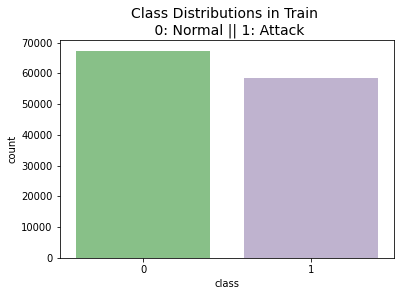

In [ ]:
import matplotlib.pyplot as plt 
import seaborn as sns
sns.countplot(x="class", data=newdf, palette="Accent")
plt.title('Class Distributions in Train \n 0: Normal || 1: Attack', fontsize=14)
plt.show()

In [ ]:
newdf_test.groupby('class').count()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_S2,flag_S3,flag_SF,flag_SH,service_http_8001,service_harvest,service_urh_i,service_aol,service_red_i,service_http_2784
class,,,,,,,,,,,,,,,,,,,,,
0,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711,...,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711
1,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833,...,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833


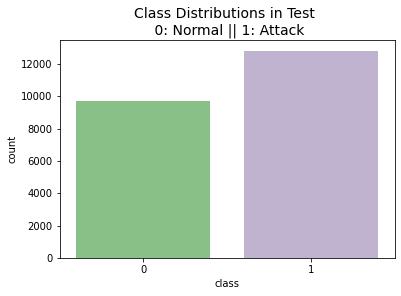

In [ ]:
sns.countplot(x="class", data=newdf_test, palette="Accent")
plt.title('Class Distributions in Test \n 0: Normal || 1: Attack', fontsize=14)
plt.show()

# Feature Selection: CFS

Loại 22 thược tính, giữ 19 (không kể nhãn kết nối)

In [ ]:
#train
newdf=newdf.drop(['duration','urgent','num_failed_logins','num_compromised','root_shell','su_attempted','num_root','num_file_creations','num_shells','num_access_files','num_outbound_cmds', 'is_host_login','is_guest_login','srv_count','srv_serror_rate','rerror_rate','srv_rerror_rate', 'srv_diff_host_rate','dst_host_count','dst_host_srv_count', 'dst_host_same_srv_rate','dst_host_srv_rerror_rate'], axis=1)
print(newdf)

#test
newdf_test=newdf_test.drop(['duration','urgent','num_failed_logins','num_compromised','root_shell','su_attempted','num_root','num_file_creations','num_shells','num_access_files','num_outbound_cmds', 'is_host_login','is_guest_login','srv_count','srv_serror_rate','rerror_rate','srv_rerror_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate','dst_host_srv_rerror_rate'],axis=1)
print(newdf_test)

        src_bytes  dst_bytes  land  wrong_fragment  hot  logged_in  count  \
0             491          0     0               0    0          0      2   
1             146          0     0               0    0          0     13   
2               0          0     0               0    0          0    123   
3             232       8153     0               0    0          1      5   
4             199        420     0               0    0          1     30   
...           ...        ...   ...             ...  ...        ...    ...   
125968          0          0     0               0    0          0    184   
125969        105        145     0               0    0          0      2   
125970       2231        384     0               0    0          1      1   
125971          0          0     0               0    0          0    144   
125972        151          0     0               0    0          1      1   

        serror_rate  same_srv_rate  diff_srv_rate  ...  flag_RSTO  \
0     

# Split the training set and testing set

In [ ]:
#'class' chính là kết quả phân loại, tách nó ra và gán vaafp tập Y - đại diện cho kết quả, phần còn lại là X
x=newdf.drop('class',1) #X-train
y=newdf["class"] #y-Train

xtest=newdf_test.drop("class",1) #X-test
ytest=newdf_test['class'] # y-test
xtest

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """


,src_bytes,dst_bytes,land,wrong_fragment,hot,logged_in,count,serror_rate,same_srv_rate,diff_srv_rate,...,flag_S2,flag_S3,flag_SF,flag_SH,service_http_8001,service_harvest,service_urh_i,service_aol,service_red_i,service_http_2784
0,0,0,0,0,0,0,229,0.0,0.04,0.06,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0
1,0,0,0,0,0,0,136,0.0,0.01,0.06,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0
2,12983,0,0,0,0,0,1,0.0,1.00,0.00,...,0.0,0.0,1.0,0.0,0,0,0,0,0,0
3,20,0,0,0,0,0,1,0.0,1.00,0.00,...,0.0,0.0,1.0,0.0,0,0,0,0,0,0
4,0,15,0,0,0,0,1,0.0,1.00,0.00,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,794,333,0,0,0,1,1,0.0,1.00,0.00,...,0.0,0.0,1.0,0.0,0,0,0,0,0,0
22540,317,938,0,0,0,1,2,0.0,1.00,0.00,...,0.0,0.0,1.0,0.0,0,0,0,0,0,0
22541,54540,8314,0,0,2,1,5,0.0,1.00,0.00,...,0.0,0.0,1.0,0.0,0,0,0,0,0,0
22542,42,42,0,0,0,0,4,0.0,1.00,0.00,...,0.0,0.0,1.0,0.0,0,0,0,0,0,0


In [ ]:
# giới hạn giá trị các thuộc tính về [0, 1], mức tối thiểu là 0, tối đa là 1
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
# Training Set
scale = MinMaxScaler()
scale= preprocessing.StandardScaler().fit(x)
x=scale.transform(x) 

# Test set
scaletest= preprocessing.StandardScaler().fit(xtest)
xtest=scaletest.transform(xtest)

## Mạng nơ-ron: RNN sử dụng LSTM

In [ ]:
from tensorflow import keras
import numpy as np
import datetime
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, recall_score, precision_score

In [ ]:
#input của LSTM dạng 3D: samples, time steps, and features

x=pd.DataFrame(x)
x = x.values
sample = x.shape[0]
features = x.shape[1]

#Train: convert 2D to 3D for input RNN
x_train = np.reshape(x,(sample,features,1)) #shape  = (125973, 101, 1)

#Test: convert 2D to 3D for input RNN
x_test=pd.DataFrame(xtest)
x_test = x_test.values
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1)) #shape (22544, 101, 1)

### Thiết lập các LTSM

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, recall_score, precision_score
from tensorflow import keras
np.random.seed(1234)
tf.random.set_seed(1234)

## LSTM 1






In [ ]:
# Using tanh and sigmoid as activation functions
# thay đổi hàm kích hoạt, số node input

Model = keras.Sequential([

        keras.layers.LSTM(80,input_shape=(features,x_train.shape[2]),
                          activation='tanh',recurrent_activation='hard_sigmoid'),
        keras.layers.Dense(1,activation="tanh")
    ])

Model.compile(optimizer='rmsprop',loss='mse', metrics=['accuracy'])

#Training the model
#Model.fit(x_train, y, epochs=10, batch_size= 32) #92.74%
Model.fit(x_train, y, validation_split=0.3, epochs= 15, batch_size= 32)
Model.summary()

# Final evaluation of the model
scores = Model.evaluate(x_test, ytest, verbose=0)
print("\n")
print("Accuracy: %.2f%%" % (scores[1]*100))


Epoch 1/15
2756/2756 [==============================] - 304s 109ms/step - loss: 0.0504 - accuracy: 0.9367 - val_loss: 0.0445 - val_accuracy: 0.9510
Epoch 2/15
2756/2756 [==============================] - 298s 108ms/step - loss: 0.0217 - accuracy: 0.9749 - val_loss: 0.0066 - val_accuracy: 0.9905
Epoch 3/15
2756/2756 [==============================] - 296s 108ms/step - loss: 0.0055 - accuracy: 0.9938 - val_loss: 0.0018 - val_accuracy: 0.9979
Epoch 4/15
2756/2756 [==============================] - 297s 108ms/step - loss: 0.0036 - accuracy: 0.9958 - val_loss: 0.0029 - val_accuracy: 0.9969
Epoch 5/15
2756/2756 [==============================] - 298s 108ms/step - loss: 0.0036 - accuracy: 0.9959 - val_loss: 8.6398e-04 - val_accuracy: 0.9990
Epoch 6/15
2756/2756 [==============================] - 301s 109ms/step - loss: 0.0025 - accuracy: 0.9973 - val_loss: 5.4849e-04 - val_accuracy: 0.9994
Epoch 7/15
2756/2756 [==============================] - 302s 110ms/step - loss: 0.0029 - accuracy: 0.996

In [ ]:
#evaluation of LSTM 
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, recall_score, precision_score
Y_pred = (Model.predict(x_test) >= 0.5).astype("int")
#Y_pred = (Model.predict(x_test))

print("accuracy score: {}%".format(round(accuracy_score(ytest, Y_pred)*100,2)))
print("f1_score: {}%".format(round(f1_score(ytest, Y_pred)*100,2)))
print("recall score: {}%".format(round(recall_score(ytest, Y_pred)*100,2)))
print("precision score: {}%".format(round(precision_score(ytest, Y_pred)*100,2)))


accuracy score: 94.77%
f1_score: 95.3%
recall score: 93.32%
precision score: 97.37%


In [ ]:
#confusion_matrix
cm_lstm1=confusion_matrix(ytest, Y_pred)
print("confusion matrix:\n",cm_lstm1)

confusion matrix:
 [[ 9388   323]
 [  857 11976]]


## LSTM 5
DropOut + LSTM 1

In [ ]:
Model_5 = Sequential()
Model_5.add(LSTM(80,input_shape=(features,x_train.shape[2]), activation='tanh',recurrent_activation='hard_sigmoid', return_sequences=True))  
Model_5.add(Dropout(0.1))
Model_5.add(LSTM(80, return_sequences=False))  
Model_5.add(Dropout(0.1))
Model_5.add(Dense(1))
Model_5.add(Activation('sigmoid'))


Model_5.compile(optimizer='rmsprop',loss='mse', metrics=['accuracy'])

#Training the model
Model_5.fit(x_train, y, epochs=10, batch_size= 32)   #91.42%


Model_5.summary()

Epoch 1/10
3937/3937 [==============================] - 612s 154ms/step - loss: 0.0375 - accuracy: 0.9550
Epoch 2/10
3937/3937 [==============================] - 609s 155ms/step - loss: 0.0077 - accuracy: 0.9905
Epoch 3/10
3937/3937 [==============================] - 604s 153ms/step - loss: 0.0025 - accuracy: 0.9970
Epoch 4/10
3937/3937 [==============================] - 607s 154ms/step - loss: 0.0013 - accuracy: 0.9985
Epoch 5/10
3937/3937 [==============================] - 611s 155ms/step - loss: 3.3626e-04 - accuracy: 0.9996
Epoch 6/10
3937/3937 [==============================] - 610s 155ms/step - loss: 3.4767e-04 - accuracy: 0.9996
Epoch 7/10
3937/3937 [==============================] - 609s 155ms/step - loss: 8.5524e-05 - accuracy: 0.9999
Epoch 8/10
3937/3937 [==============================] - 610s 155ms/step - loss: 1.5778e-04 - accuracy: 0.9998
Epoch 9/10
3937/3937 [==============================] - 605s 154ms/step - loss: 5.5196e-05 - accuracy: 0.9999
Epoch 10/10
3937/3937 [===

In [ ]:
scores = Model_5.evaluate(x_test, ytest, verbose=0)
print("\n")
print("Accuracy: %.2f%%" % (scores[1]*100))



Accuracy: 95.98%


In [ ]:
Y_pred = (Model_5.predict(x_test) >= 0.5).astype("int")
#Y_pred = (Model.predict(x_test))

print("accuracy score: {}%".format(round(accuracy_score(ytest, Y_pred)*100,2)))
print("f1_score: {}%".format(round(f1_score(ytest, Y_pred)*100,2)))
print("recall score: {}%".format(round(recall_score(ytest, Y_pred)*100,2)))
print("precision score: {}%".format(round(precision_score(ytest, Y_pred)*100,2)))

accuracy score: 95.98%
f1_score: 96.36%
recall score: 93.36%
precision score: 99.55%


In [ ]:
#confusion_matrix
cm_lstm5=confusion_matrix(ytest, Y_pred)
print("confusion matrix:\n",cm_lstm5)

confusion matrix:
 [[ 9657    54]
 [  852 11981]]
